In [2]:
import pandas as pd
import glob

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

from ipywidgets import SelectMultiple, interactive_output, VBox
from IPython.display import display

import datetime as dt

import json

In [3]:
def get_file_date(file_name):
    year, month, day = int(file_name.split('_')[-1][:4]), int(file_name.split('_')[-1][4:6]), int(file_name.split('_')[-1][6:8])
    return dt.date(year, month, day)

In [4]:
# Reading the latest file

cases_files = pd.DataFrame(data=glob.glob(r'./data/nhs_infections/*.csv'), columns=['file'])

cases_files['date'] = cases_files['file'].apply(get_file_date)

latest_file = cases_files.iloc[np.argmax(cases_files['date'])]['file']

cases_df = pd.read_csv(latest_file)

# Convertine to datetime column
cases_df['Date'] = pd.to_datetime(cases_df['Specimen date'])

# Feature Engineering

In [70]:
# This will be used to create delta_time features

imp_dates = {
    'cases_over_100':[dt.datetime(2020,3,2),dt.datetime(2020,12,31)],
    'schools_closed':[dt.datetime(2020,3,15),dt.datetime(2020,5,31)],
    'restaurants_cafes_closed':[dt.datetime(2020,3,20),dt.datetime(2020,6,30)],
    'nationwide_lockdown':[dt.datetime(2020,3,23),dt.datetime(2020,8,31)]
}

In [72]:
# Creating a dataframe for each unique area code, these are districts / cities in England, i.e. Harrow, Brent, etc.
# df for each unique area stored in dictionary

areawise_data = {}

for area in cases_df['Area code'].unique():
    areawise_data[area] = cases_df[cases_df['Area code']==area].sort_values('Date').drop_duplicates(subset=['Date'])

In [73]:
for area_code in areawise_data:
    area_df = areawise_data[area_code]
    
    # Storing rolling mean to new columns
    
    area_df['rolling_mean_3'] = area_df['Cumulative lab-confirmed cases'].rolling(3).mean()
    area_df['rolling_mean_7'] = area_df['Cumulative lab-confirmed cases'].rolling(7).mean()
    
    cases_data = area_df['Cumulative lab-confirmed cases'].ravel()
    
    gradient_n7 = []
    gradient_n3 = []
    gradient_0 = []
    current_r0 = []
    
    
    for i in range(cases_data.shape[0]):
        if i>=7:
            
            # Using np.gradient to collect data of change in cases in past 7 days
            # These gradients can be used as features for mlp or regressors
            
            gradient = np.gradient([cases_data[i-7], cases_data[i-4], cases_data[i-1]])
            gradient_n7.append(gradient[0])
            gradient_n3.append(gradient[1])
            gradient_0.append(gradient[2])
            
            # calculating current r0
            current_r0.append((cases_data[i-1] - cases_data[i-3])/(cases_data[i-4]-cases_data[i-6]))
        else:
            
            gradient_n7.append(np.nan)
            gradient_n3.append(np.nan)
            gradient_0.append(np.nan)
            current_r0.append(np.nan)

    area_df['grad_0'] = gradient_0
    area_df['grad_n3'] = gradient_n3
    area_df['grad_n7'] = gradient_n7
    area_df['current_r0'] = current_r0
    area_df['rolling_r0_3'] = area_df['current_r0'].rolling(3).mean()
    area_df['rolling_r0_7'] = area_df['current_r0'].rolling(7).mean()

    area_df['K_value_1'] = np.log(area_df['grad_n3']/3)
    area_df['K_value_2'] = np.log(area_df['grad_n3'])/3
    areawise_data[area_code] = area_df.iloc[8:]

In [74]:
def add_lag_featuers(df, date_col, imp_dates):
    for imp_measure, imp_dates in imp_dates.items():
        df[imp_measure+'_startdelta'] = df[date_col].apply(lambda x : (x - imp_dates[0]).days)
        df[imp_measure+'_enddelta'] = df[date_col].apply(lambda x : (x - imp_dates[1]).days)
        df[imp_measure+'_active'] = df[date_col].apply(lambda x : int(x >= imp_dates[0] and x <= imp_dates[1]))
    return df

In [75]:
cases_data = pd.concat([df for df in areawise_data.values()])

cases_data = add_lag_featuers(cases_data, 'Date', imp_dates)

cases_data.to_pickle(r'./data/processed/cases_data.pickle')

In [76]:
demo_uk = pd.read_csv(r'./data/regional/population_density_age.csv')

In [77]:
demo_uk.sample(3)

,Area code,name,median age,population density,population density deciles,Age 0 to 15,Age 65 plus,Age 85 plus,Working age 16 to 64,Old Age Dependency Ratio,Dependency Ratio
148,E07000129,Blaby,42.9,781,6,19.1,20.3,2.7,60.6,33.6,65.1
303,E09000023,Lewisham,35.2,8738,10,20.5,9.5,1.3,70.0,13.5,42.8
363,S12000045,East Dunbartonshire,46.4,624,6,17.9,22.5,3.1,59.6,37.8,67.7


In [78]:
all_data = pd.merge(cases_data, demo_uk, on='Area code')

In [79]:
all_data['ref_r0'] = all_data['Cumulative lab-confirmed cases']/(all_data['Cumulative lab-confirmed cases'] - all_data['grad_n3'])

In [80]:
all_data[all_data['Area code']=='E09000033'][['Cumulative lab-confirmed cases', 'grad_n7', 'grad_n3', 'grad_0', 'Date', 'ref_r0', 'current_r0','rolling_r0_3', 'K_value_1', 'K_value_2']].iloc[10:100].drop_duplicates(subset=['Date'])

,Cumulative lab-confirmed cases,grad_n7,grad_n3,grad_0,Date,ref_r0,current_r0,rolling_r0_3,K_value_1,K_value_2
10,132,29.0,28.5,28.0,2020-03-20,1.275362,0.947368,1.182456,2.251292,1.116635
11,145,29.0,31.0,33.0,2020-03-21,1.271930,1.000000,1.071345,2.335375,1.144662
12,157,33.0,35.0,37.0,2020-03-22,1.286885,1.473684,1.140351,2.456736,1.185116
13,179,28.0,34.0,40.0,2020-03-23,1.234483,1.388889,1.287524,2.427748,1.175454
14,195,33.0,40.0,47.0,2020-03-24,1.258065,1.416667,1.426413,2.590267,1.229626
15,218,37.0,43.5,50.0,2020-03-25,1.249284,1.357143,1.387566,2.674149,1.257587
16,238,40.0,50.5,61.0,2020-03-26,1.269333,1.560000,1.444603,2.823361,1.307324
17,251,47.0,53.0,59.0,2020-03-27,1.267677,1.264706,1.393950,2.871680,1.323431
18,271,50.0,53.0,56.0,2020-03-28,1.243119,0.868421,1.231042,2.871680,1.323431
19,289,61.0,57.0,53.0,2020-03-29,1.245690,0.846154,0.993094,2.944439,1.347684


In [81]:
sample_data = all_data[all_data['Area code']=='E08000015']

In [82]:
all_data.drop(columns=['Previously reported daily cases', 'Change in daily cases', 'Previously reported cumulative cases', 'Change in cumulative cases'], inplace=True)

# Visualising Newly Created Features

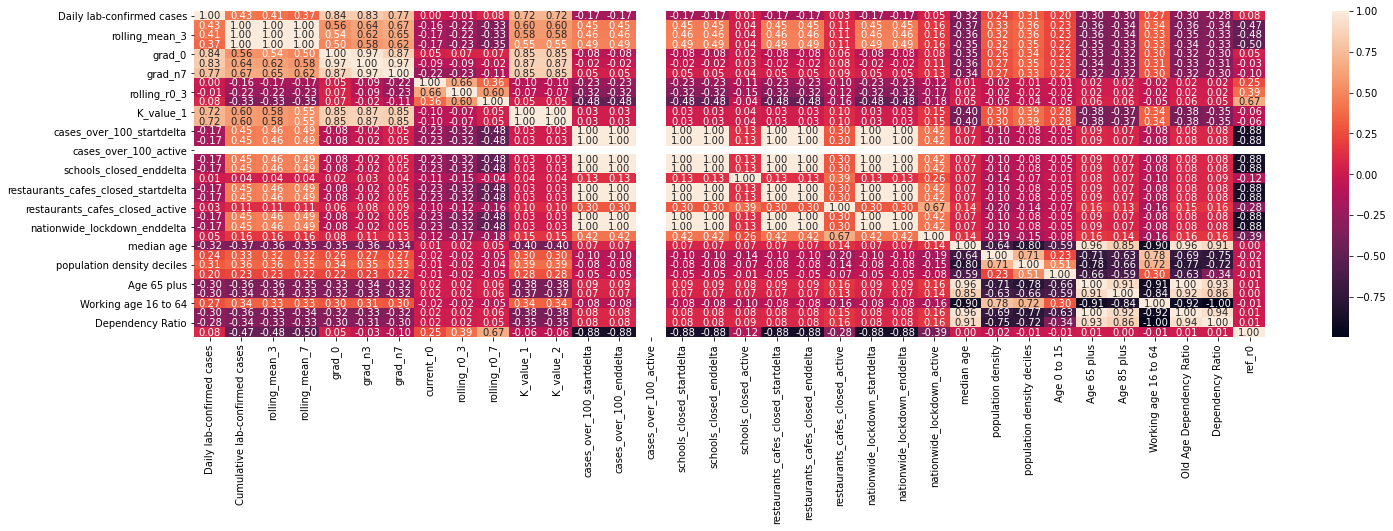

In [84]:
plt.figure(figsize=(24,6))
sns.heatmap(all_data.corr(), annot=True, fmt='.2f')

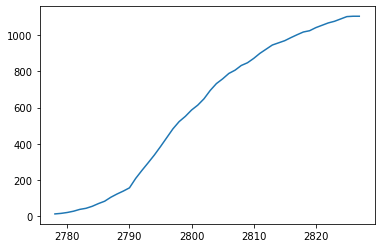

In [57]:
sample_data['Cumulative lab-confirmed cases'].plot()

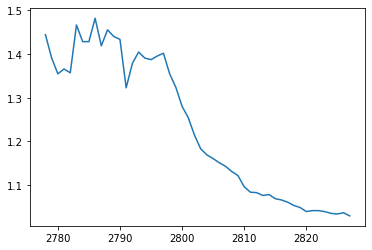

In [58]:
sample_data['ref_r0'].plot()

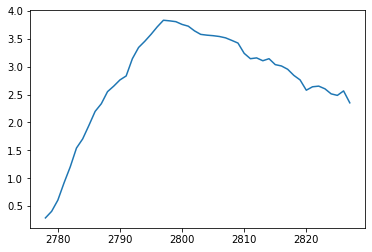

In [59]:
sample_data['K_value_1'].plot()

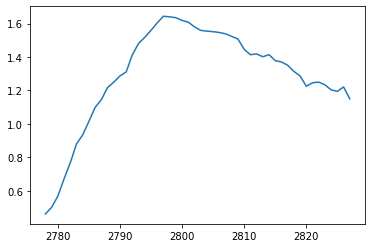

In [60]:
sample_data['K_value_2'].plot()

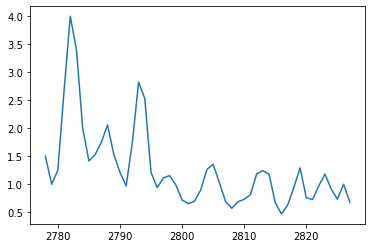

In [61]:
sample_data['current_r0'].plot()

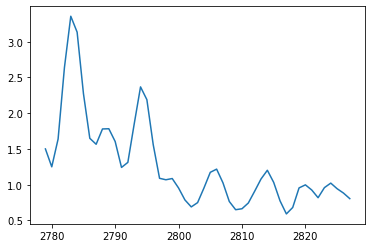

In [62]:
sample_data['rolling_r0_3'].plot()

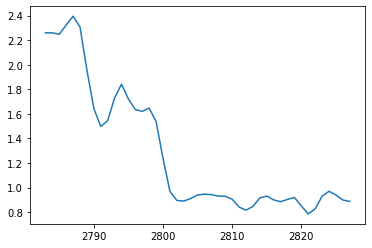

In [63]:
sample_data['rolling_r0_7'].plot()

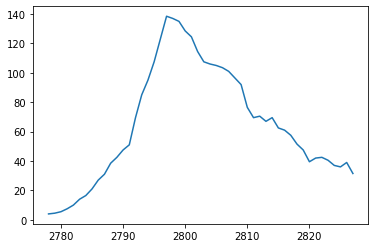

In [64]:
sample_data['grad_n3'].plot()

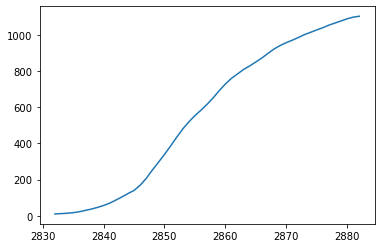

In [224]:
all_data[all_data['Area code']=='E08000015']['rolling_mean_3'].plot()

In [87]:
all_data[['schools_closed_startdelta', 'schools_closed_enddelta', 'Date', 'schools_closed_active']].sample(10)

,schools_closed_startdelta,schools_closed_enddelta,Date,schools_closed_active
2833,11,-66,2020-03-26,1
13539,47,-30,2020-05-01,1
9210,43,-34,2020-04-27,1
13502,51,-26,2020-05-05,1
4332,47,-30,2020-05-01,1
4020,23,-54,2020-04-07,1
10442,9,-68,2020-03-24,1
4251,43,-34,2020-04-27,1
7724,43,-34,2020-04-27,1
2245,23,-54,2020-04-07,1


# Adding Area Data

In [88]:
areas_uk = pd.read_csv(r'./data/regional/areas_uk.csv')

In [91]:
missing_areas = set(all_data['Area code'].unique()) - set(areas_uk['Area code'].unique())

In [96]:
areas_data = all_data[['Area name', 'Area code']].drop_duplicates().reset_index().drop(columns=['index'])

In [99]:
areas_data[areas_data['Area code'].isin(missing_areas)]

,Area name,Area code
69,Somerset West and Taunton,E07000246
70,West Suffolk,E07000245
71,East Suffolk,E07000244
257,Dorset,E06000059
258,"Bournemouth, Christchurch and Poole",E06000058


In [100]:
all_data = pd.merge(all_data, areas_uk, on='Area code')

In [101]:
all_data.info

,Area name,Area code,Area type,Specimen date,Daily lab-confirmed cases,Cumulative lab-confirmed cases,Date,rolling_mean_3,rolling_mean_7,grad_0,...,Age 85 plus,Working age 16 to 64,Old Age Dependency Ratio,Dependency Ratio,ref_r0,LAD16NM,AREAEHECT,AREACHECT,AREAIHECT,AREALHECT
0,Westminster,E09000033,Upper tier local authority,2020-03-10,6.0,24,2020-03-10,18.000000,11.571429,9.0,...,1.7,70.6,17.7,41.6,1.500000,Westminster,2203.01,2148.70,0.0,2148.70
1,Westminster,E09000033,Upper tier local authority,2020-03-11,14.0,38,2020-03-11,26.666667,16.571429,13.0,...,1.7,70.6,17.7,41.6,1.381818,Westminster,2203.01,2148.70,0.0,2148.70
2,Westminster,E09000033,Lower tier local authority,2020-03-12,14.0,52,2020-03-12,38.000000,23.428571,26.0,...,1.7,70.6,17.7,41.6,1.485714,Westminster,2203.01,2148.70,0.0,2148.70
3,Westminster,E09000033,Lower tier local authority,2020-03-13,8.0,60,2020-03-13,50.000000,30.714286,34.0,...,1.7,70.6,17.7,41.6,1.558442,Westminster,2203.01,2148.70,0.0,2148.70
4,Westminster,E09000033,Lower tier local authority,2020-03-14,10.0,70,2020-03-14,60.666667,39.142857,36.0,...,1.7,70.6,17.7,41.6,1.538462,Westminster,2203.01,2148.70,0.0,2148.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13618,Hartlepool,E06000001,Lower tier local authority,2020-05-02,3.0,221,2020-05-02,218.000000,206.428571,18.0,...,2.5,61.4,31.7,63.0,1.094059,Hartlepool,9844.17,9355.95,0.0,9355.95
13619,Hartlepool,E06000001,Lower tier local authority,2020-05-03,1.0,222,2020-05-03,220.333333,211.428571,10.0,...,2.5,61.4,31.7,63.0,1.082927,Hartlepool,9844.17,9355.95,0.0,9355.95
13620,Hartlepool,E06000001,Lower tier local authority,2020-05-04,7.0,229,2020-05-04,224.000000,216.571429,7.0,...,2.5,61.4,31.7,63.0,1.067599,Hartlepool,9844.17,9355.95,0.0,9355.95
13621,Hartlepool,E06000001,Lower tier local authority,2020-05-05,1.0,230,2020-05-05,227.000000,220.857143,11.0,...,2.5,61.4,31.7,63.0,1.067285,Hartlepool,9844.17,9355.95,0.0,9355.95


In [102]:
all_data.to_pickle(r'./data/processed/all_data.pickle')